## Setup libraries

In [1]:
from icevision.all import *
import icedata
import pandas as pd

## Setup Training

In [2]:
DEBUG = False
MODEL = 'YOLO'
SINGLE_LABEL = True
image_size = 512 ## multipile of 32 for yolo, multiple of 128 else

## Get Data

In [3]:
#path = Path('src/png_512wFrame')
#path = Path('/media/veracrypt1/Data Science/SIIM-Imgs/png_1024wFrame')
path = Path('/media/veracrypt2/Data Science/SIIM-Imgs/kaggle_covid_jpg_prep')


df = pd.read_pickle('src/train_ready_1024_wFrame.pkl')

Shrink the dataframe

In [6]:
if DEBUG:
    df = df.sample(n = 1500).reset_index(drop = True)
    print('Using smaller dataset for debugging')
else:
    print('Training on full dataset')

Training on full dataset


In [7]:
print(df.shape)
df.head(2)

(6333, 11)


id StudyInstanceUID  Negative for Pneumonia  Typical Appearance  \
0  000a312787f2     5776db0cec75                       0                   1   
1  000c3a3f293f     ff0879eb20ed                       1                   0   

   Indeterminate Appearance  Atypical Appearance  \
0                         0                    0   
1                         0                    0   

                                                                                         boxes_list  \
0  [[789.28836, 582.43035, 1815.94498, 2499.73327], [2245.91208, 591.20528, 3340.5737, 2352.75472]]   
1                                                                            [[0.0, 0.0, 1.0, 1.0]]   

          labels_list     label orig_width orig_height  
0  [Typical, Typical]   Typical       4256        3488  
1          [Negative]  Negative       2832        2320

In [11]:
def get_id_from_fn(fn):
    return re.match('.*_.*_(.*)', str(fn.stem))[1]

In [13]:
## Switch to single label
if SINGLE_LABEL:
    # derive background labele from default bbox
    df['label'] = df['boxes_list'].apply(lambda x: 'background' if (x == [[0.,0.,1.,1.]]).all() else 'opacity')

In [14]:
items = get_image_files(path/'1024px/train')
#items = L([fn for fn in items if fn.stem in df.id.tolist()])
items = L([fn for fn in items if get_id_from_fn(fn) in df.id.tolist()])

print(len(items))

6333


In [15]:
def add_filepath(items, df):
    for fn in items:
        #df.loc[df.id == fn.stem, 'filepath'] = fn
        df.loc[df.id == get_id_from_fn(fn), 'filepath'] = fn        

In [16]:
add_filepath(items, df)
df.head(1)

id StudyInstanceUID  Negative for Pneumonia  Typical Appearance  \
0  000a312787f2     5776db0cec75                       0                   1   

   Indeterminate Appearance  Atypical Appearance  \
0                         0                    0   

                                                                                         boxes_list  \
0  [[789.28836, 582.43035, 1815.94498, 2499.73327], [2245.91208, 591.20528, 3340.5737, 2352.75472]]   

          labels_list    label orig_width orig_height  \
0  [Typical, Typical]  opacity       4256        3488   

                                                                                                                       filepath  
0  /media/veracrypt2/Data Science/SIIM-Imgs/kaggle_covid_jpg_prep/1024px/train/train/5776db0cec75_81456c9c5423_000a312787f2.jpg

## Build icevision Parser

In [18]:
template_record = ObjectDetectionRecord()

In [19]:
class SIIMParser(Parser):
    def __init__(self, template_record, data_dir, df):
        super().__init__(template_record = template_record)
        
        self.data_dir = data_dir
        self.df = df
        self.class_map = ClassMap(list(self.df['label'].unique()))
        
    def __iter__(self):
        for o in self.df.itertuples():
            yield o
            
    def __len__(self):
        return len(self.df)
    
    def record_id(self, o):
        return o.id
    
    def parse_fields(self, o, record, is_new):
        if is_new:
            record.set_img_size(ImgSize(o.orig_width, o.orig_height))
            record.set_filepath(o.filepath)
            record.detection.set_class_map(self.class_map)    
        
        if o.label == 'opacity':
            for box in o.boxes_list:
                #box = (box /  (o.orig_width+1) * 1024)
                xmin, ymin = box[:2] 
                xmax, ymax = box[2:] 
                record.detection.add_labels([o.label])
                record.detection.add_bboxes([BBox.from_xyxy(xmin / o.orig_width * 1024, ymin / o.orig_height * 1024, xmax / o.orig_width * 1024, ymax / o.orig_height * 1024)])

In [20]:
parser = SIIMParser(template_record, path, df)

In [21]:
train_records, valid_records = parser.parse()

  0%|          | 0/6333 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/6333 [00:00<?, ?it/s]

AUTOFIX-SUCCESS - (record_id: 6ea732c63929) - Clipping bbox xmin from -0.8554778947368421 to 0 (Before: <BBox (xmin:-0.8554778947368421, ymin:472.35016807339446, xmax:332.57121684210523, ymax:996.4175060550458)>) | icevision.utils.logger_utils:autofix_log:17


In [22]:
parser.class_map

<ClassMap: {'background': 0, 'opacity': 1}>

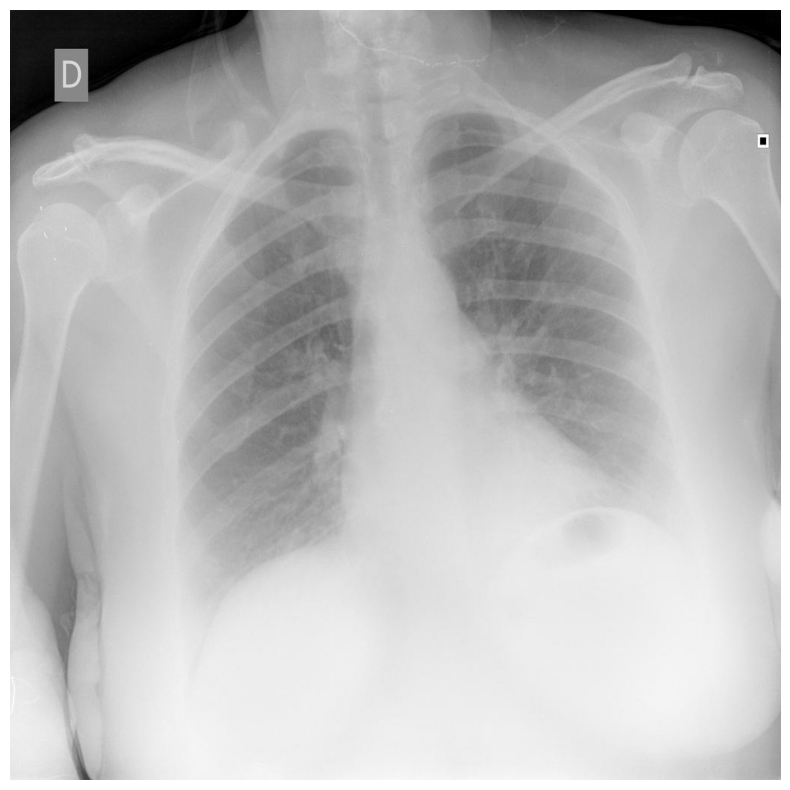

In [23]:
one_record = train_records[2]
show_record(one_record, display_label = True, figsize = (14, 10))

In [24]:
aug_tfms = tfms.A.aug_tfms(
    size = image_size, 
    presize = 640, 
    #horizontal_flip = None,
    #shift_scale_rotate = tfms.A.ShiftScaleRotate(
    #    always_apply=False,
    #    p=0.5,
    #    shift_limit_x=(-0.0225, 0.0225),
    #    shift_limit_y=(-0.0225, 0.0225),
    #    scale_limit=(-0.03000000000000009, 0.03000000000000009),
    #    rotate_limit=(-5, 5)
    #),
    rgb_shift = None,
    #lightning = tfms.A.RandomBrightnessContrast(
    #    always_apply=False,
    #    p=0.5,
    #    brightness_limit=(-0.1, 0.1),
    #    contrast_limit=(-0.1, 0.1),
    #    brightness_by_max=True,
    #),
    blur = None,
    crop_fn = None,
)

train_tfms = tfms.A.Adapter([*aug_tfms, tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

In [25]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

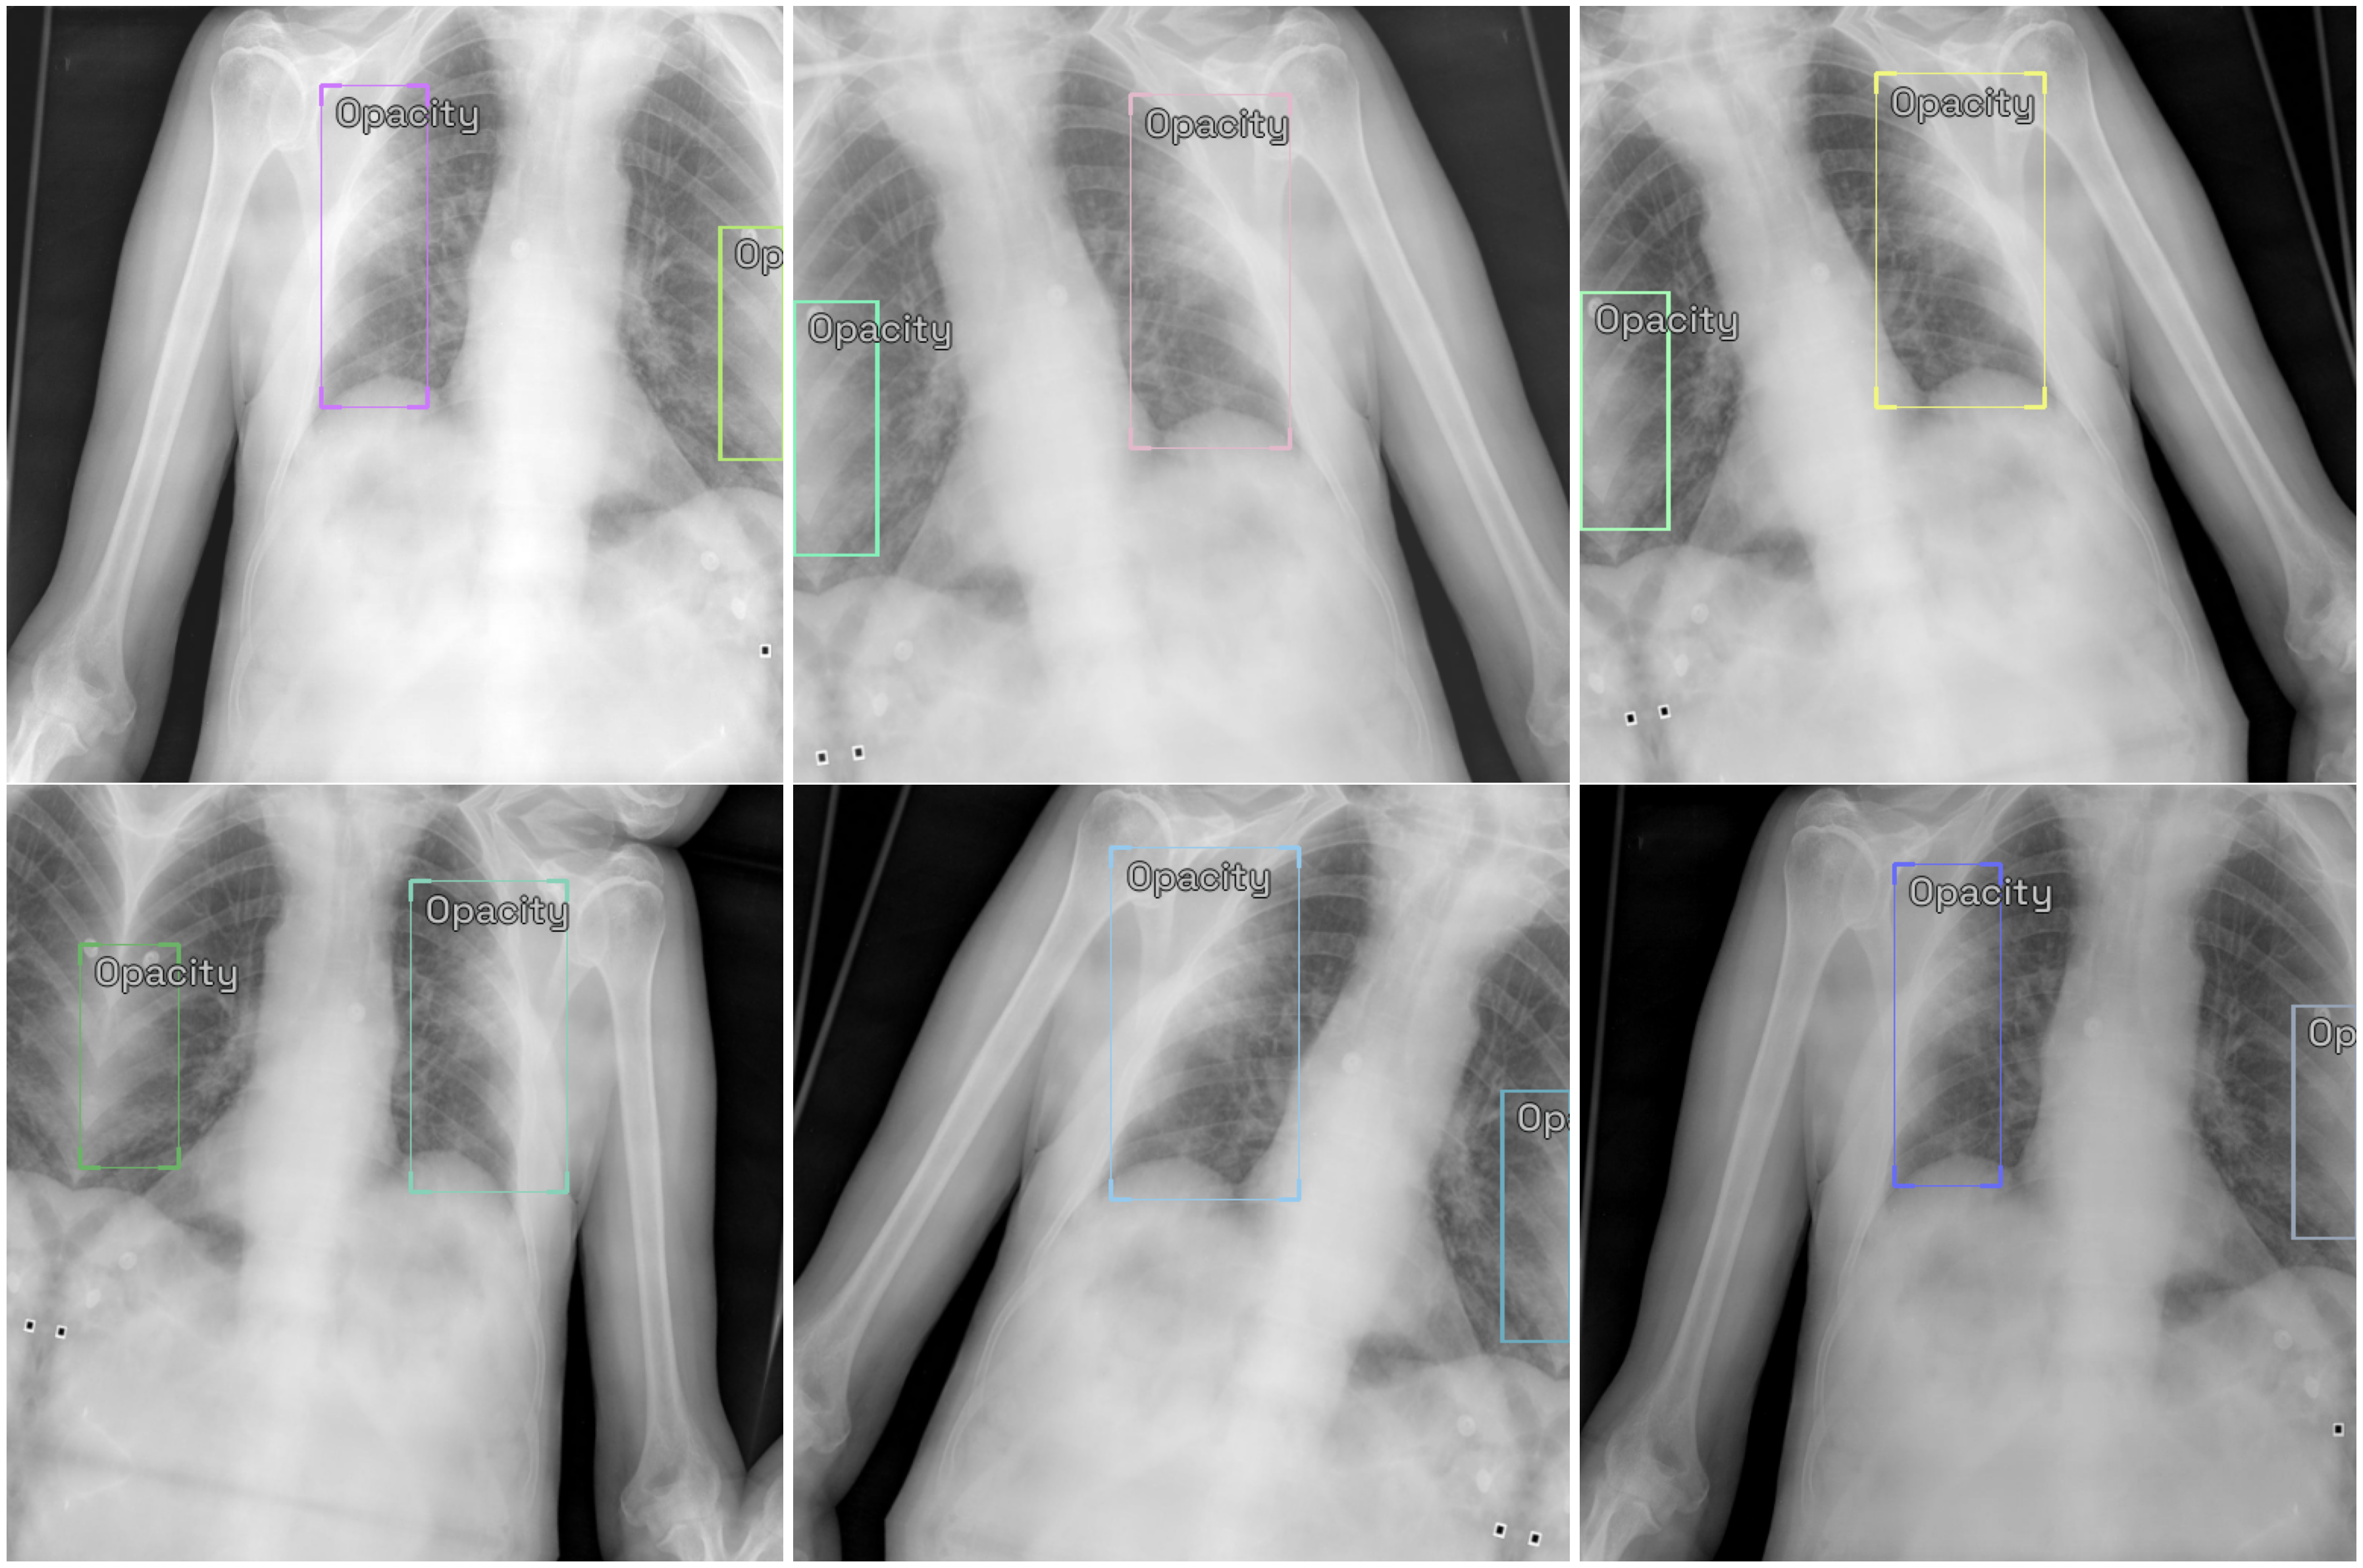

In [26]:
samples = [train_ds[0] for _ in range(6)]
show_samples(samples, ncols = 3)

In [27]:
extra_args = {}
if MODEL == 'YOLO':
    model_type = models.ultralytics.yolov5
    backbone = model_type.backbones.large(pretrained = True)
    extra_args['img_size'] = image_size
    extra_args['device'] = torch.device('cuda')
    print('Using YoloV5')
elif MODEL == 'FASTER':
    model_type = models.torchvision.faster_rcnn
    backbone = model_type.backbones.resnext50_32x4d_fpn(pretrained=True)
    print('Using Faster RCNN')
elif MODEL == 'EFFDET':
    model_type = models.ross.efficientdet
    backbone = model_type.backbones.tf_lite0(pretrained = True)
    extra_args['img_size'] = image_size
    print('Using EfficientDet')
elif MODEL == 'RETINA':
    model_type = models.torchvision.retinanet
    backbone = model_type.backbones.resnext50_32x4d_fpn(pretrained = True)
    print('Using RetinaNet')
else: 
    print('Please pick a model!')

Using YoloV5


In [28]:
model = model_type.model(
    backbone = backbone,
    num_classes = len(parser.class_map),
    **extra_args
)

In [29]:
train_dl = model_type.train_dl(
    train_ds, 
    batch_size = 8,
    num_workers = 6,
    shuffle = True
)

valid_dl = model_type.valid_dl(
    valid_ds,
    batch_size = 8,
    num_workers = 6,
    shuffle = False
)

In [30]:
#model_type.show_batch(first(valid_dl), ncols = 2)

In [31]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [32]:
learn = model_type.fastai.learner(
    dls = [train_dl, valid_dl],
    model = model, 
    metrics = metrics,
)#.to_fp16()

SuggestedLRs(lr_min=0.0006309573538601399, lr_steep=6.309573450380412e-07)

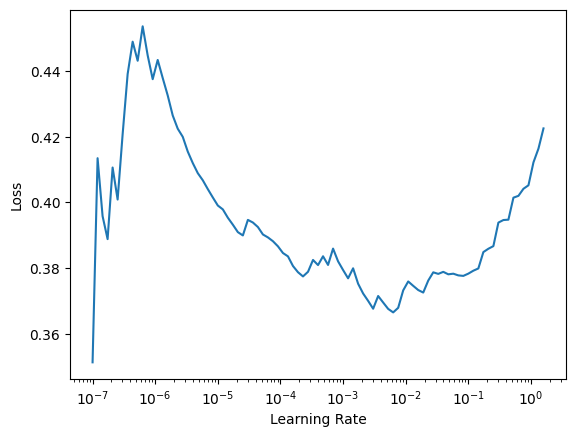

In [33]:
learn.lr_find()

In [34]:
learn.fine_tune(epochs = 10, base_lr = 1e-3)#, freeze_epochs = 5)

In [ ]:
#learn.lr_find()

In [ ]:
#learn.fit_one_cycle(20, lr_max = slice(2e-6,1e-4))

## Show results

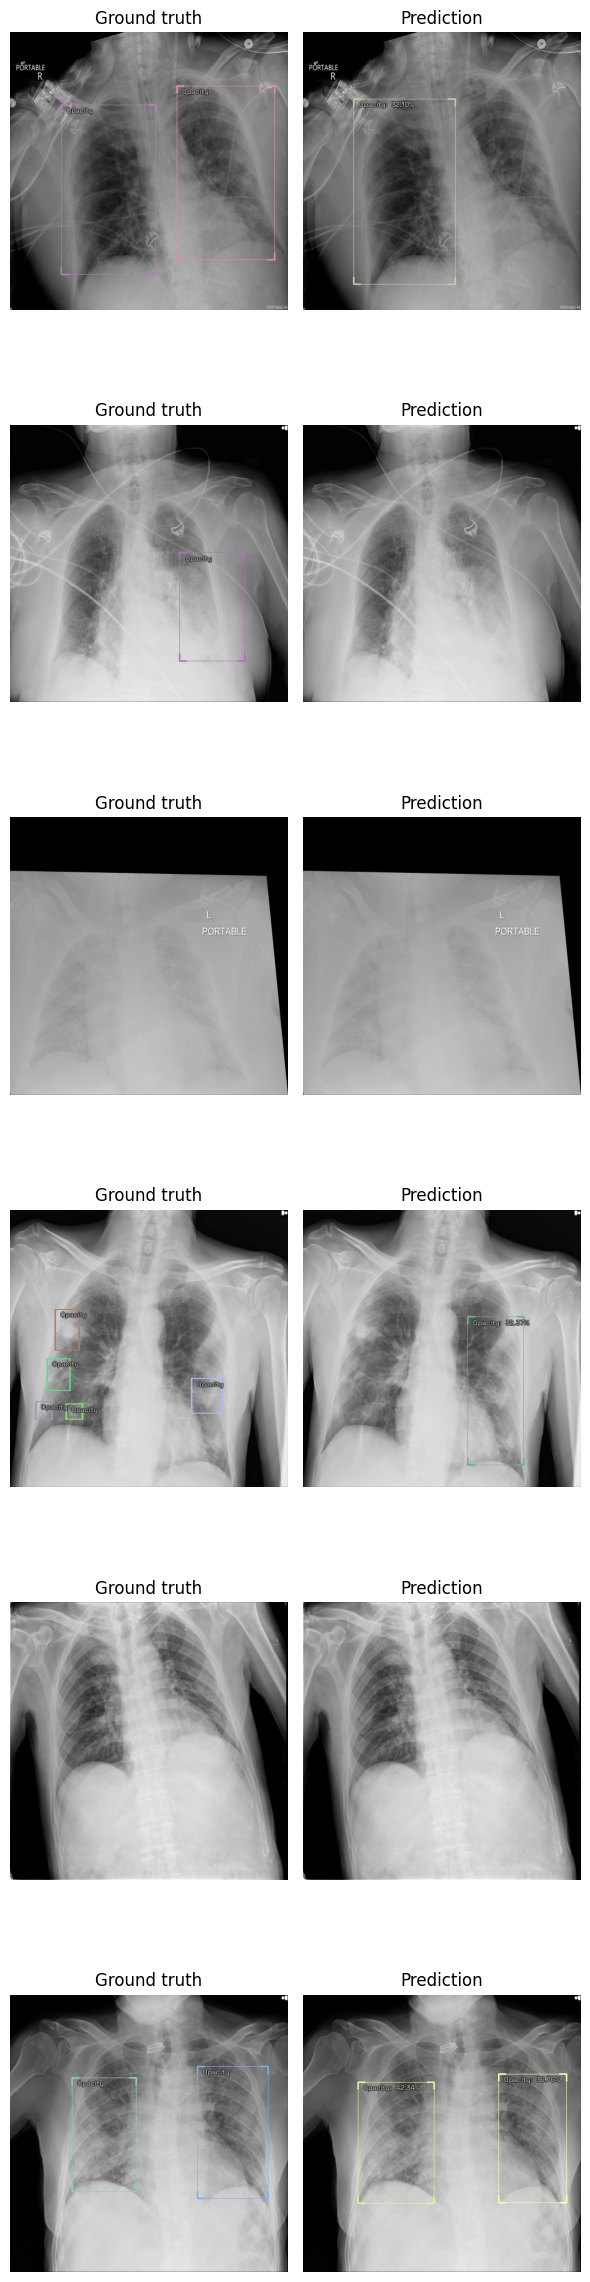

In [35]:
model_type.show_results(model, valid_ds, detection_threshold = 0.3)